# The Bancor Protocol
Based on the whitepaper from: Eyal Hertzog, Guy Benartzi, Galia Benartzi, "The Bancor Protocol" March, 2018

8/22/18

Written for: [Horuspay.io](https://horuspay.io/)

By: gunnar pope

* github: https://github.com/gunnarpope
* email: gunnarpope@gmail.com


Forward: This script in intended to explore and expand upon the brilliance of the Bancor Protocol Algorithm presented by Hertzong, et al. Any critiques provided below are intended to build upon and clarify their work. -gp




### Definitions and notes on the Bancor Algorithm:

* $TOK$ is the your native Smart Token symbol, which could be HORUS for example
* $CTOK$ is the connector token that you wish to transfer, which could be EOS, BTC, or even ETH, if desired.
* [USD/TOK] the brakets indicate only the units of the variable, in this case the unit is USD/TOK
* From the whitepaper, "The price of a Smart Token is denominated in the connected token (for example, the price of BNT is denominated in ETH, its connected token"
* 'The bancor formula is built upon the idea that the smart contract maintains a ratio between the total value and the connector valance, the connector weight.'

### Total Smart Token Supply
The Smart Token Total Supply, $totalTOKsupply$, is the maximum amount of Smart Tokens of your contract to ever be created.


### Smart Token Market Cap
The total market capitalization of the Smart Token, $TOK$, is the total value of the $TOK$ market, in reference of the connector token, $CTOK$. The $TOKmarketCap$ variable must be in units of [CTOK] for $CW$ to be a unitless number. Therefore, the whitepaper formula for $TOKmarketCap$ should be modified to be:

$$TOKmarketcap [CTOK]= price [CTOK/TOK]*totalTOKsupply[TOK]$$


For instance, if the total supply of EOS ever created was 1000 EOS, than the $TOKmarketcap$ would be:

$$ TOKmarketcap =  0.00074823558[BTC/EOS] * 1000 EOS = 0.74680 BTC $$.

### Connector Weight
From the Price Formula algorithms:

$$ CW = \frac{CTOKbalance [CTOK]}{TOKmarketcap [CTOK]}$$

where:

Where, $CTOKbalance$ is the balance of the tokens in the connector account.


A few small notes: 
 * The whitepaper states that: "The CW is expressed as a percentage greater than 0% and up to 100%, and as mentioned, is initially set by the creator when a Smart Token is configured." 
 
 
 
If this were true, and $CTOKbalance$ and $TOKmarketcap$ are of the same units, than the equation for $CW$ would have to be:
$$ CW = \frac{CTOKbalance [CTOK]}{TOKmarketcap [CTOK]}*100$$



But this would scale $price$ calculation to be artificially low (I think), so it is probably ranging between $0 < CW < 1$.


### Smart Token Price

The price of the smart token is denominated (referrenced to) the connector token. For example, if EOS is the Smart token and BTC is the connector token, and 1 EOS = 0.00074823558 BTC, than the units of $price$ are:

$$ price =  0.00074823558 [BTC/EOS]$$.


In reference to this algorithm, the units of price are.
$$ price = XX.XXXX [CTOK/TOK]$$


Solve for the Smart Token's price as a function of it's connector weight, $CW$, connector balance, $CTOKbalance$, and Smart Token supply, $TOKsupply$.  The $Smart Token Outstanding Supply$ is not defined in the Bancor whitepaper, but we're assuming it represents available supply of $TOK$ to the smart contract, $TOKsupply$. This $TOKsupply$ would have to be a liquid balance of $TOK$, owned by the Smart Contract administrators, to be usefully traded.


$$ price [CTOK/TOK] = \frac{CTOKBalance [CTOK]}{TOKsupply [TOK]*CW}$$

This formula implies that if there is a large outstanding supply (low demand), the token will be worth a fraction of it's marketcap price and if only a few tokens are available in supply (high demand), each token will be worth nearly the marketcap price.


#### Tokens Issued 


$$ TOKissued [TOK] = TOKsupply [TOK]*\big((1+(\frac{CTOKrecieved [CTOK]}{CTOKbalance [CTOK]})^{CW}-1\big)$$

This is the amount of Smart Tokens to payout given the current smart token supply, $TOKsupply$, the connected tokens paid, $CTOKrecieved$, and the balance of $CTOK$ tokens in the bancor account, $CTOKbalance$.


$$ CTOKissued = CTOKbalance * ((1+ \frac{TOKrecieved}{TOKsupply})^{\frac{1}{CW}}-1) $$

The effective price can be calculated as:

$$ effectivePrice  [CTOK/TOK] = \frac{CTOKexchanged [CTOK]}{TOKexchanged [TOK]}$$

The $effectivePrice$ represents the effective exchange rate of the transaction, in units of $[CTOK/TOK]$




In [24]:
# The Bancor Algorithm and testing
class smart_token:
    def __init__(self, name, supply, totalsupply):
        self.name = name                     #"TOK"
        self.supply = supply                 #[TOK] circulating supply
        self.totalsupply = totalsupply       #[TOK] total TOK created
    
    def printtok(self):
        print("Token Stats:")
        print("Token: ", self.name)
        print("Supply: ", self.supply)
        print("totalsupply: ",  self.totalsupply)
        
    
class connector:
    def __init__(self, tokenname, balance):
        self.token   = tokenname   # name="CTOK", for example
        self.balance = balance     # [CTOK] balance

        
    def printcon(self):
        print("Connector Stats:")
        print("Token: ", self.token)
        print("Balance: ", self.balance)

    
class BancorExchange:
    
    def __init__(self, CW):
        self.CW = CW
        self.price = 0.0
        self.effective_price = 0.0

    def printf(self):
        print("CW: ", self.CW)
        print("Price: ", self.price)
        
    def CTOKtoTOK(self, tok, ctok, CTOKreceived):
        
        # get TOK supply
        TOKsupply = tok.totalsupply
        
        # get price
        self.price = self.getprice(tok, ctok)
        
        # get TOKmarketcap
        marketcap = self.marketcap(self.price, tok.totalsupply)
        
        # compute TOKissued
        TOKissued = self.TOKissued(TOKsupply, ctok.balance, CTOKreceived, CW)
        
        # compute the effective price
        
        # remove TOK from TOKbalance
        tok.supply -= TOKissued
        
        # add CTOK to CTOKbalance
        ctok.balance += CTOKreceived
        
        # calculate the effective price
        self.effective_price =   CTOKreceived/ (1.0*TOKissued)
    
        # update the new marketcap
        newmarketcap = self.marketcap(self.effective_price, tok.totalsupply)
        
        # update the CW
        self.CW = self.updateCW(ctok.balance, newmarketcap)
        
        # return TOKissued and effective price
        return (TOKissued)
    
    def TOKtoCTOK(self, tok, ctok, TOKreceived):
        
        
        # get price
        self.price = self.getprice(tok, ctok)
        
        # get TOKmarketcap
        marketcap = self.marketcap(self.price, tok.totalsupply)
        
        # compute CTOKissued
        CTOKissued = self.CTOKissued(tok.totalsupply, ctok.balance, TOKreceived, CW)
        
        # remove TOK from TOKbalance
        ctok.balance -= CTOKissued
        
        # add CTOK to CTOKbalance
        tok.supply += TOKreceived
        
        # calculate the effective price
        self.effective_price =   CTOKissued/ (1.0*TOKreceived)
    
        # update the new marketcap
        newmarketcap = self.marketcap(self.effective_price, tok.totalsupply)
        
        # update the CW
        self.CW = self.updateCW(ctok.balance, newmarketcap)
        
        # return TOKissued and effective price
        return (CTOKissued)
        
        
    
        
    def updateCW(self, CTOKbalance, TOKmarketcap):
        CW = CTOKbalance / TOKmarketcap
        return (CW)
        
    def getprice(self, tok, ctok):
        balance   = ctok.balance
        TOKsupply = tok.supply
        price = balance/(TOKsupply*self.CW)
#         print("Price [EOS/HOR]:", price)
        return ( price )
    
    def marketcap(self,price, totalTOKsupply):
        marketcap = price * totalTOKsupply
        return ( marketcap )
    
    def CTOKissued(self, TOKsupply, CTOKbalance, TOKreceived, CW ):
        
        ctokissued = CTOKbalance * (( 1 + TOKreceived/TOKsupply)**(1/CW)-1 )
 
        return ( ctokissued )

    def TOKissued(self, TOKsupply, CTOKbalance, CTOKreceived, CW):
        
        tokensissued = TOKsupply*( (1+CTOKreceived/CTOKbalance)**(CW) -1)

        return( tokensissued )
                                   
                                

###########################################


# eoscon.price = 1
# eoscon.get_balanceValue()

# find the supply of HORUS on the EOS MAINNET
# $ cleos --url https://api.eosnewyork.io:443  get currency stats horustokenio "HORUS"
# {
#   "HORUS": {
#     "supply": "1200000000.0000 HORUS",
#     "max_supply": "1200000000.0000 HORUS",
#     "issuer": "horustokenio"
#   }

In [25]:
HORUSsupply = 1000.0000
HORUScirc   = 1000.0000

# horus_supply = np.linspace(1000,2000,1000)
horus = smart_token("HORUS", HORUScirc, HORUSsupply)

EOSbalance = 250 #0.5*bancor.get_tokmarketcap(horus,eoscon) # this creates a CW of 0.50
eos = connector("EOS",EOSbalance)

CW = 0.50
exchange = BancorExchange(CW)

print("TOKsupply:\t", horus.supply)
print("EOSbalance\t", eos.balance)

CTOKrecieved = 10
for i in list(range(10)):
    TOKissued = exchange.CTOKtoTOK(tok=horus,ctok=eos,CTOKreceived=CTOKrecieved)
    
    print()
    print("TOK Issued:\t",     TOKissued)
    print("TOKsupply:\t",      horus.supply)
    print("EOSbalance:\t",     eos.balance)
    print("CW:\t\t",           exchange.CW)
    print("Effective Price: ", exchange.effective_price)
    
    
   


TOKsupply:	 1000.0
EOSbalance	 250

TOK Issued:	 19.803902718557033
TOKsupply:	 980.1960972814429
EOSbalance:	 260
CW:		 0.5149014706824829
Effective Price:  0.5049509756796375

TOK Issued:	 19.049330730136262
TOKsupply:	 961.1467665513067
EOSbalance:	 270
CW:		 0.514331929713679
Effective Price:  0.5249528259898331

TOK Issued:	 18.350154434631172
TOKsupply:	 942.7966121166755
EOSbalance:	 280
CW:		 0.5138043241696728
Effective Price:  0.5449545416973487

TOK Issued:	 17.700489198214875
TOKsupply:	 925.0961229184607
EOSbalance:	 290
CW:		 0.5133141867482313
Effective Price:  0.5649561369754977

TOK Issued:	 17.095255431215595
TOKsupply:	 908.000867487245
EOSbalance:	 300
CW:		 0.5128576629364678
Effective Price:  0.5849576240750518

TOK Issued:	 16.530045465127152
TOKsupply:	 891.4708220221179
EOSbalance:	 310
CW:		 0.5124314094189417
Effective Price:  0.6049590136395355

TOK Issued:	 16.001016001524036
TOKsupply:	 875.4698060205939
EOSbalance:	 320
CW:		 0.5120325120487692
Effective 

## Conclusion:
The example above works pefectly according to the whitepaper.

### Test: EOS->HORUS
Start with an initial balance of 2000 HORUS and 250 EOS and observe how the price of HORUS changes with each exchange from EOS to Horus.

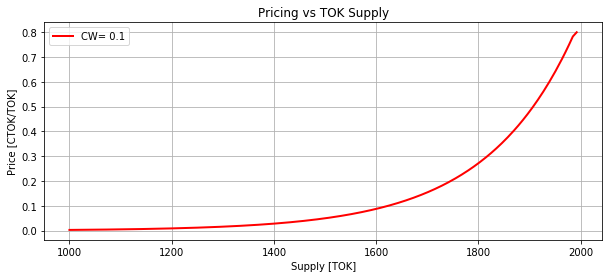

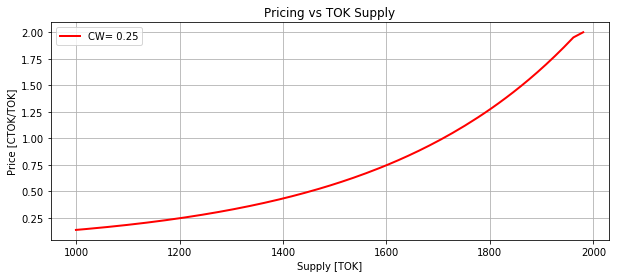

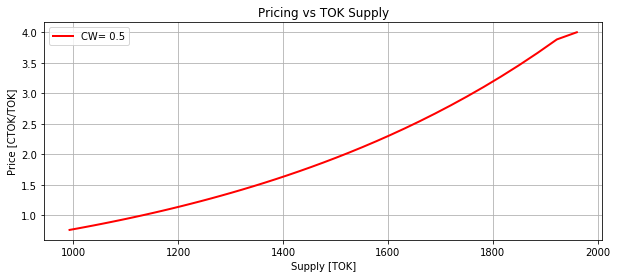

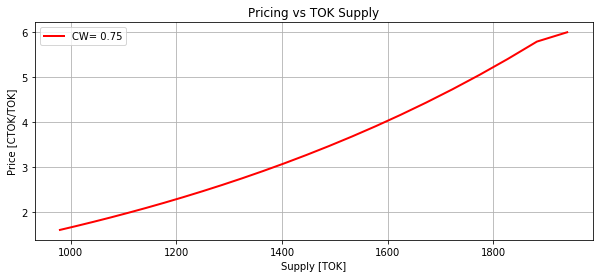

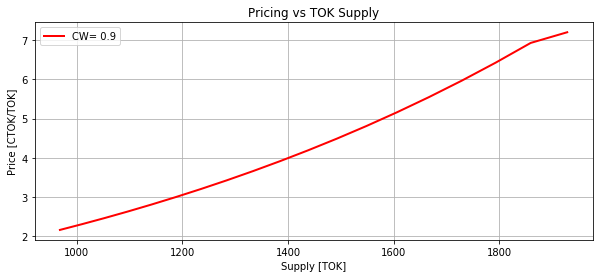

In [26]:
import numpy as np
import matplotlib.pyplot as plt

for CW in [0.1, 0.25, 0.50, 0.75, 0.90]:
    ex = BancorExchange(CW)
    HORUSsupply = 2000.0000
    HORUScirc   = 2000.0000

    # horus_supply = np.linspace(1000,2000,1000)
    horus = smart_token("HORUS", HORUScirc, HORUSsupply)

    EOSbalance = 250 #0.5*bancor.get_tokmarketcap(horus,eoscon) # this creates a CW of 0.50
    eos = connector("EOS",EOSbalance)



    price = []
    hsupplylist = []
    hsupply = horus.supply
    while (hsupply > 1000):

    # print("TOKsupply:\t", horus.supply)
    # print("EOSbalance\t", eos.balance)

        CTOKrecieved = 10
        TOKissued = ex.CTOKtoTOK(tok=horus,ctok=eos,CTOKreceived=CTOKrecieved)
        hsupplylist.append(horus.supply)
#         price.append(ex.price)
        price.append(1/ex.price) # flip units to [Horus/EOS]. Correct?
        hsupply = horus.supply

    
    plt.figure(figsize=(10,4))
    plt.plot(hsupplylist, price,'r', linewidth=2,label="CW= "+str(CW))
    plt.title("Pricing vs TOK Supply")
    plt.legend()
    plt.ylabel("Price [CTOK/TOK]")
    plt.xlabel("Supply [TOK]")
#     plt.axis([900,2100,0,1.5])
    plt.grid(True)
    plt.show()
    


### Test: HORUS->EOS
Start with an initial balance of 1000 HORUS and 250 EOS and observe how the price of HORUS changes with each exchange from HORUS to EOS.

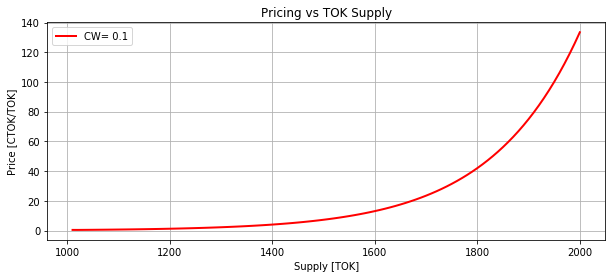

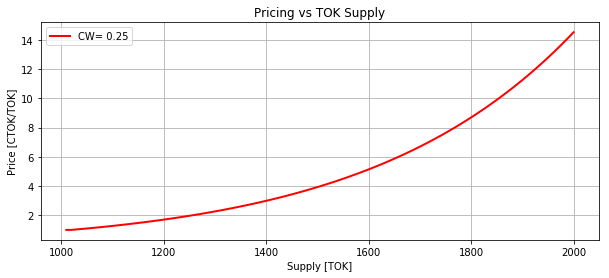

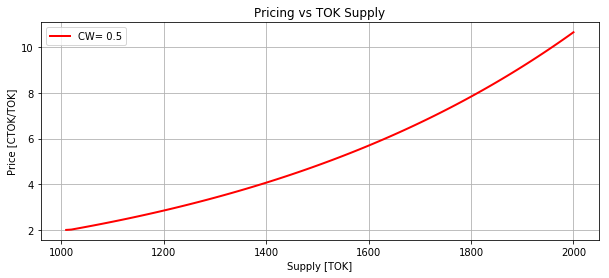

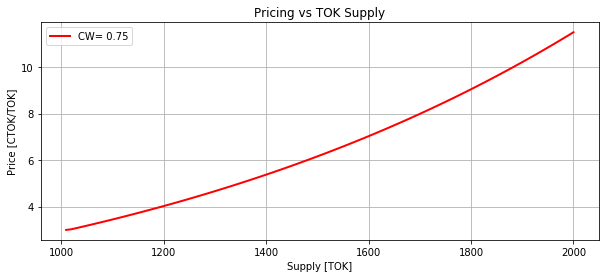

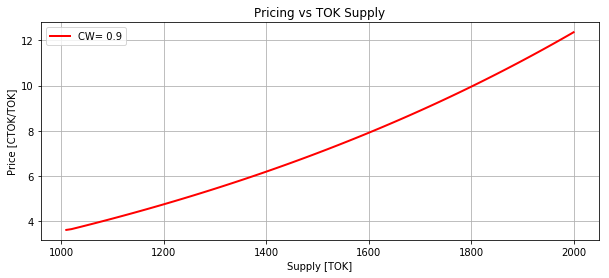

In [27]:
import numpy as np
import matplotlib.pyplot as plt

for CW in [0.1, 0.25, 0.50, 0.75, 0.90]:
    
    ex = BancorExchange(CW)
    HORUSsupply = 2000.0000
    HORUScirc   = 1000.0000

    # horus_supply = np.linspace(1000,2000,1000)
    horus = smart_token("HORUS", HORUScirc, HORUSsupply)

    EOSbalance = 250 #0.5*bancor.get_tokmarketcap(horus,eoscon) # this creates a CW of 0.50
    eos = connector("EOS",EOSbalance)



    price = []
    hsupplylist = []
    hsupply = horus.supply
    while (hsupply < 2000):

        TOKrecieved = 10
        CTOKissued = ex.TOKtoCTOK(tok=horus, ctok=eos, TOKreceived=TOKrecieved)
#         print(CTOKissued)
        hsupplylist.append(horus.supply)
#         price.append(ex.price)
        price.append(1/ex.price) # this flips the units to [Horus/EOS]. Correct?
        hsupply = horus.supply

    
    plt.figure(figsize=(10,4))
    plt.plot(hsupplylist, price,'r', linewidth=2,label="CW= "+str(CW))
    plt.title("Pricing vs TOK Supply")
    plt.legend()
    plt.ylabel("Price [CTOK/TOK]")
    plt.xlabel("Supply [TOK]")
#     plt.axis([900,2100,0,1.5])
    plt.grid(True)
    plt.show()
    


## Conclusion
The basics of the bancor algorithm are listed above. These plots don't quite match the Bancor whitepaper exactly so we should see where their algorithm differs from ours. Some of the initial balance values will make the plots differ in their scale, but the share should be similar.

### ToDo: 
* Incorporate the 10 day time lag into the formula 
* Produce some test cases to make sure the algorithm works
* code it up in EOS!
